In [2]:
import torch 
from torch import nn 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device 

'cpu'

torchvision built-in dataset - https://pytorch.org/vision/stable/datasets.html#built-in-datasets

our dataset is a subset of the Food101 dataset. 

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing). 
Our dataset starts with 3 classes of food and only 10% of the images(~75 training, 25 testing). 

In [4]:
import requests 
import zipfile 
from pathlib import Path 

data_path = Path("data/") 
image_path = data_path / "pizza_steak_sushi" 

if image_path.is_dir(): 
    print(f"{image_path} directory already exists... skipping download") 
else: 
    print(f"{image_path} does not exist, creating one...") 
    image_path.mkdir(parents=True, exist_ok=True) 
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f: 
        # raw data 주소 가져오기 
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip") 
        print("Downloading pizza, steak, sushi dataa...") 
        f.write(request.content) 
        
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref: 
        print("Unzipping pizza, steak and sushi data...") 
        zip_ref.extractall(image_path) 

data\pizza_steak_sushi directory already exists... skipping download


In [5]:
import os 

def walk_through_dir(dir_path): 
    """Walks through dir_path returing its contents.""" 
    
    for dirpath, dirnames, filenames in os.walk(dir_path): 
        print(f"현재 경로: {dirpath}, 하위 폴더 개수: {len(dirnames)}, 하위 파일 개수: {len(filenames)}") 

In [6]:
walk_through_dir("data/pizza_steak_sushi") 

현재 경로: data/pizza_steak_sushi, 하위 폴더 개수: 2, 하위 파일 개수: 0
현재 경로: data/pizza_steak_sushi\test, 하위 폴더 개수: 3, 하위 파일 개수: 0
현재 경로: data/pizza_steak_sushi\test\pizza, 하위 폴더 개수: 0, 하위 파일 개수: 25
현재 경로: data/pizza_steak_sushi\test\steak, 하위 폴더 개수: 0, 하위 파일 개수: 19
현재 경로: data/pizza_steak_sushi\test\sushi, 하위 폴더 개수: 0, 하위 파일 개수: 31
현재 경로: data/pizza_steak_sushi\train, 하위 폴더 개수: 3, 하위 파일 개수: 0
현재 경로: data/pizza_steak_sushi\train\pizza, 하위 폴더 개수: 0, 하위 파일 개수: 78
현재 경로: data/pizza_steak_sushi\train\steak, 하위 폴더 개수: 0, 하위 파일 개수: 75
현재 경로: data/pizza_steak_sushi\train\sushi, 하위 폴더 개수: 0, 하위 파일 개수: 72


In [7]:
train_dir = image_path / "train" 
test_dir = image_path / "test" 

train_dir, test_dir 

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

data\pizza_steak_sushi\test\sushi\2394442.jpg
sushi


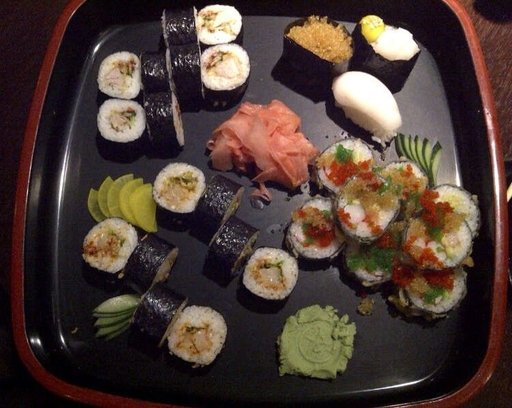

In [8]:
import random 
from PIL import Image 

random.seed(42) 

image_path_list = list(image_path.glob("*/*/*.jpg"))  # train or test / pizza or steack or susshi / *.jpg   

random_image_path = random.choice(image_path_list) 
print(random_image_path) 

image_class = random_image_path.parent.stem 
print(image_class) 

img = Image.open(random_image_path) 
img 

### Transforming data 

In [9]:
import torch 
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms 

In [10]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor(),  # CHW , tensor , 0.0 ~ 1.0 
])

In [11]:
transformed_img = data_transform(img) 
print(transformed_img.shape) 
print(transformed_img.dtype)
print(transformed_img.min(), transformed_img.max())

torch.Size([3, 64, 64])
torch.float32
tensor(0.) tensor(1.)


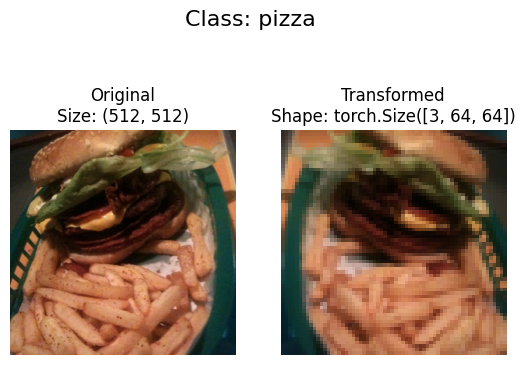

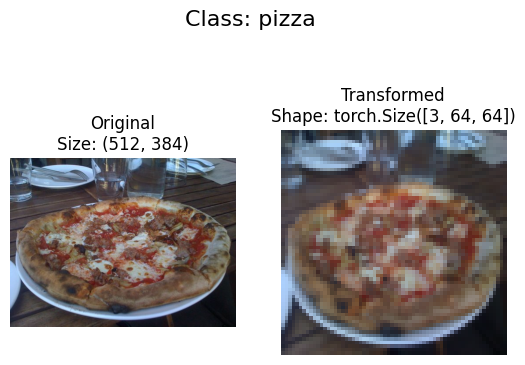

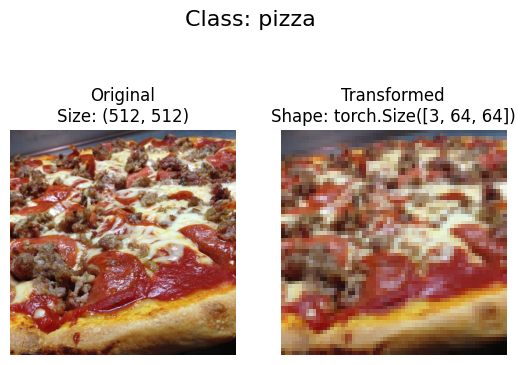

In [12]:
import matplotlib.pyplot as plt 

def plot_transformed_images(image_paths, transform, n=3, seed=None): 
    if seed: 
        random.seed(seed) 
        
    random_image_paths = random.sample(image_paths, k=n) 
    for image_path in random_image_paths: 
        with Image.open(image_path) as f: 
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original\nSize: {f.size}") 
            ax[0].axis(False) 
            
            transformed_image = transform(f)  
            ax[1].imshow(transformed_image.permute(1, 2, 0)) 
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}") 
            ax[1].axis(False) 
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16) 
            
plot_transformed_images(image_path_list, data_transform)
            

### Dataset
* ImageFolder 
* CustomDataset 

In [13]:
target_directory = train_dir 
print(f"Target dir: {target_directory}") 

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))]) 
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [14]:
import os 
import pathlib 
import torch 

from PIL import Image 
from torch.utils.data import Dataset 
from torchvision import transforms 


class ImageFolderCustom(Dataset): 
    def __init__(self, target_dir, transform): 
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg")) 
        self.transform = transform 
        self.classes, self.class_to_idx = self._find_classes(target_dir) 
        
    def _find_classes(self, target_dir): 
        """return class_name and class_to_idx""" 
        classes = sorted(entry.name for entry in os.scandir(target_dir) if entry.is_dir()) 
        
        if not classes: 
            raise FileNotFoundError(f"Couldn't find any classes in {target_dir}... please check file structure.") 
        
        class_to_idx = {class_name: i for i, class_name in enumerate(classes)} 
        
        return classes, class_to_idx 
    
    def load_image(self, index): 
        """opens an image via a path and return it.""" 
        
        image_path = self.paths[index] 
        return Image.open(image_path) 
    
    def __len__(self): 
        return len(self.paths) 
    
    def __getitem__(self, index): 
        img = self.load_image(index) 
        class_name = self.paths[index].parent.name 
        class_idx = self.class_to_idx[class_name] 
        
        if self.transform: 
            img = self.transform(img)
        
        return img, class_idx 

In [15]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor()
]) 

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.ToTensor()
])

In [16]:
train_data_custom = ImageFolderCustom(target_dir=train_dir, transform=train_transforms) 
test_data_custom = ImageFolderCustom(target_dir=test_dir, transform=test_transforms)

In [17]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [18]:
train_data_custom.classes 

['pizza', 'steak', 'sushi']

In [19]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
def display_random_images(dataset, classes, n=10, display_shape=True, seed=None): 
    if n > 10: 
        n = 10 
        display_shape = False 
        print("For display, purposes, n shouldn't be larget than 10, setting to 10 and removing shape display") 
        
    if seed: 
        random.seed(seed) 
        
    random_sample_idx = random.sample(range(len(dataset)), k=n) 
    
    plt.figure(figsize=(16, 8)) 
    
    for i, target_sample in enumerate(random_sample_idx): 
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1] 
        
        target_image_adjust = target_image.permute(1, 2, 0) 
        
        plt.subplot(1, n, i+1) 
        plt.imshow(target_image_adjust) 
        plt.axis(False) 
        
        if classes: 
            title = classes[target_label] 
            if display_shape: 
                title = title + f"\n{target_image_adjust.shape}" 
        plt.title(title) 
                

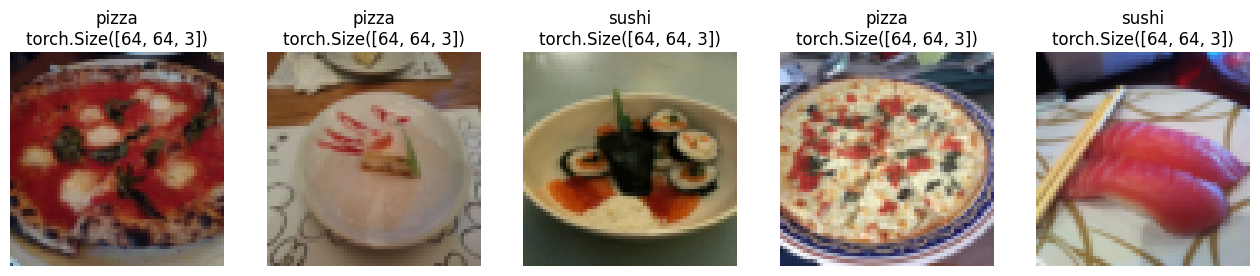

In [21]:
display_random_images(train_data_custom, n=5, classes=train_data_custom.classes, seed=None)

In [22]:
from torch.utils.data import DataLoader 

BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False) 

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1c84bd8ec50>,
 <__main__.ImageFolderCustom at 0x1c84be9a3d0>)

In [23]:
from torchvision import transforms 

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  
    transforms.ToTensor() 
]) 

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.ToTensor() 
])


In [24]:
image_path_list = list(image_path.glob("*/*/*.jpg")) 
image_path_list[:10] 

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

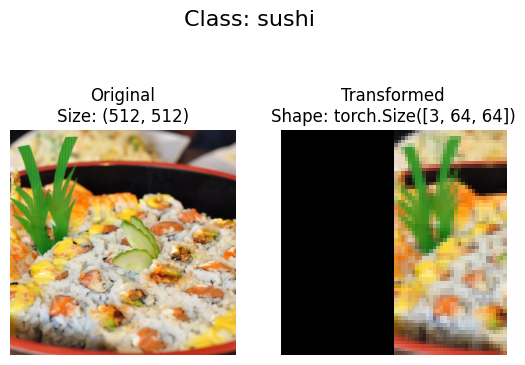

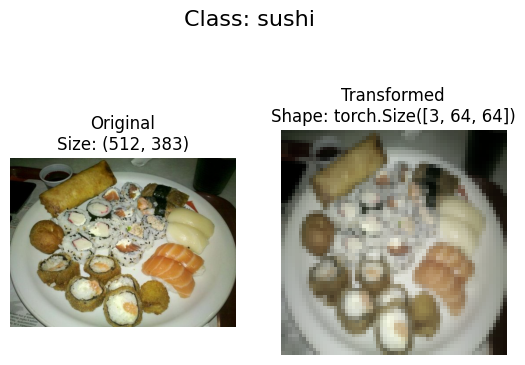

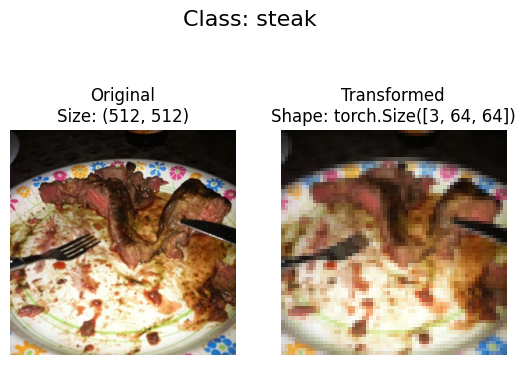

In [25]:
plot_transformed_images(image_paths=image_path_list, transform=train_transform, n=3)

In [26]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

In [27]:
from torchvision import datasets 

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform) 
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform) 

train_dataloader_simple = DataLoader(dataset=train_data_simple,  
                                     batch_size=32, 
                                     shuffle=True, 
                                     num_workers=0) 
test_dataloader_simple = DataLoader(dataset=test_data_simple, 
                                    batch_size=32, 
                                    shuffle=False, 
                                    num_workers=0) 



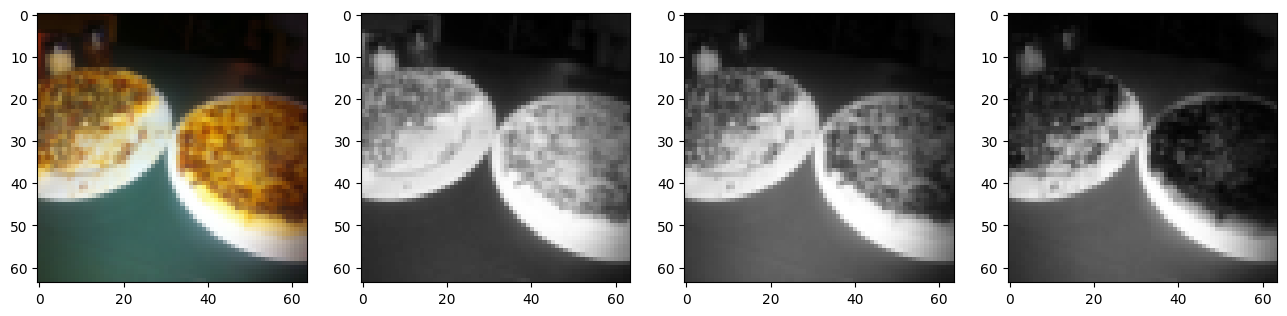

In [28]:
img, label = train_data_simple[0] 

plt.figure(figsize=(16, 8))

plt.subplot(1, 4, 1) 
plt.imshow(img.permute(1, 2, 0))

plt.subplot(1, 4, 2) 
plt.imshow(img[0], cmap='gray') 

plt.subplot(1, 4, 3) 
plt.imshow(img[1], cmap='gray') 

plt.subplot(1, 4, 4) 
plt.imshow(img[2], cmap='gray') 

plt.show() 


In [43]:
from torch import nn 

class TinyVGG(nn.Module): 
    def __init__(self, input_shape, hidden_unit, output_shape): 
        super().__init__() 
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_unit, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2) 
        ) 
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=hidden_unit*13*13, out_features=output_shape) 
        )
        
    def forward(self, x): 
        x = self.layer_1(x) 
        # print(x.shape)
        x = self.layer_2(x) 
        # print(x.shape)
        x = self.classifier(x) 
        return x
        

In [44]:
torch.manual_seed(42) 

model_0 = TinyVGG(3, 10, 3).to(device) 

model_0 

TinyVGG(
  (layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [45]:
image_batch, label_batch = next(iter(train_dataloader_simple)) 
image_batch.shape, label_batch.shape 

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [46]:
model_0(image_batch.to(device)) 

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6414e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4989e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1758e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5490e-03],
        [ 2.0768e-02

In [47]:
from torchinfo import summary 

summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [92]:
def train_step(model, dataloader, loss_fn, optimizer, device): 
    train_loss, train_acc = 0, 0 
    
    model.train() 
    for batch, (X, y) in enumerate(dataloader): 
        X, y = X.to(device), y.to(device)  
        
        y_pred = model(X) 
        y_pred_class = torch.softmax(y_pred, dim=-1).argmax(dim=-1)
        
        loss = loss_fn(y_pred, y) 
        train_loss += loss.item() 
        
        train_acc += (y_pred_class == y).sum().item() / len(X)
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)  
    
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn, device): 
    test_loss, test_acc = 0, 0
    
    model.eval()
    with torch.inference_mode(): 
        for batch, (X, y) in enumerate(dataloader): 
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X) 
            
            loss = loss_fn(test_pred_logits, y) 
            test_loss += loss.item() 
            
            test_pred_labels = test_pred_logits.argmax(dim=-1)
            test_acc += (test_pred_labels == y).sum().item() / len(X) 
            
        test_loss /= len(dataloader) 
        test_acc /= len(dataloader) 
    
    return test_loss, test_acc 

In [93]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device): 
    results = {
        "train_loss": [], 
        "train_acc": [], 
        "test_loss": [], 
        "test_acc": [] 
    }
    
    for epoch in range(epochs): 
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device) 
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device) 
        
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
        
        results["train_loss"].append(train_loss) 
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss) 
        results["test_acc"].append(test_acc)
        
    return results 

In [94]:
# without augmentation

from timeit import default_timer as timer 

torch.manual_seed(42) 
torch.cuda.manual_seed(42) 

EPOCHS = 50

model_0 = TinyVGG(3, 10, 3).to(device) 

loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

start_time = timer() 
model_0_results = train(model_0, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, EPOCHS, device) 
end_time = timer() 

print(f"Total training time: {end_time - start_time:.3f} sec")  

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0977 | Test acc: 0.3600
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0853 | Test acc: 0.4133
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0909 | Test acc: 0.4267
Epoch: 3 | Train loss: 1.0842 | Train acc: 0.3984 | Test loss: 1.0761 | Test acc: 0.4667
Epoch: 4 | Train loss: 1.0662 | Train acc: 0.4141 | Test loss: 1.0688 | Test acc: 0.4933
Epoch: 5 | Train loss: 1.0307 | Train acc: 0.4375 | Test loss: 1.0292 | Test acc: 0.4400
Epoch: 6 | Train loss: 0.9881 | Train acc: 0.4219 | Test loss: 0.9928 | Test acc: 0.4800
Epoch: 7 | Train loss: 0.9560 | Train acc: 0.5859 | Test loss: 1.0239 | Test acc: 0.4800
Epoch: 8 | Train loss: 0.9180 | Train acc: 0.5977 | Test loss: 1.0212 | Test acc: 0.4133
Epoch: 9 | Train loss: 0.9987 | Train acc: 0.4648 | Test loss: 1.0125 | Test acc: 0.4533
Epoch: 10 | Train loss: 0.8624 | Train acc: 0.5273 | Test loss: 1.0435 | Test acc: 0.4533
Epoch: 11 | Train lo

In [96]:
model_0_results

{'train_loss': [1.1063191890716553,
  1.0998141169548035,
  1.0868636071681976,
  1.0842489302158356,
  1.0662299245595932,
  1.030724085867405,
  0.9881095290184021,
  0.9560285285115242,
  0.9179690629243851,
  0.9986537843942642,
  0.8624396026134491,
  0.9302485212683678,
  0.7864951137453318,
  0.9080052375793457,
  0.7831670865416527,
  0.7465268224477768,
  0.7678297236561775,
  0.7369842529296875,
  0.7664700299501419,
  0.7641849592328072,
  0.7793555855751038,
  0.7706453502178192,
  0.7236423455178738,
  0.8630989491939545,
  0.6419124724343419,
  0.7012983411550522,
  0.6289071664214134,
  0.652910627424717,
  0.5951670398935676,
  0.7556786462664604,
  0.658197209239006,
  0.5764025351963937,
  0.5814615478739142,
  0.587682705372572,
  0.5618042889982462,
  0.5758657027035952,
  0.5933109931647778,
  0.6506320536136627,
  0.6909312084317207,
  0.6277788393199444,
  0.7204201966524124,
  0.7106306776404381,
  0.6278615482151508,
  0.6980078928172588,
  0.6862364932894707,


In [80]:
def plot_loss_curves(results): 
    loss = results["train_loss"] 
    test_loss = results["test_loss"] 
    
    accuracy = results["train_acc"] 
    test_accuracy = results["test_acc"] 
    
    epochs = range(len(results["train_loss"])) 
    
    plt.figure(figsize=(10, 5)) 
    
    plt.subplot(1, 2, 1) 
    plt.plot(epochs, loss, label="train_loss") 
    plt.plot(epochs, test_loss, label="test_loss") 
    plt.title("Loss") 
    plt.xlabel("Epochs") 
    plt.legend() 
    
    plt.subplot(1, 2, 2) 
    plt.plot(epochs, accuracy, label="train_acc") 
    plt.plot(epochs, test_accuracy, label="test_acc") 
    plt.title("Accuracy") 
    plt.xlabel("Epochs") 
    plt.legend();  

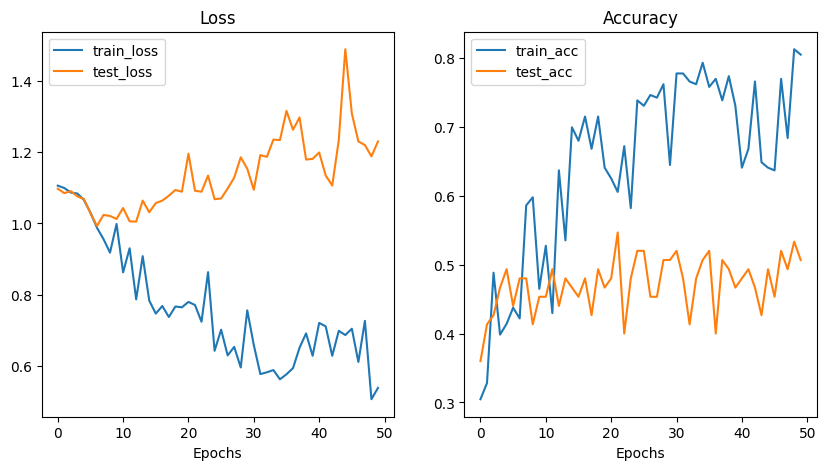

In [98]:
plot_loss_curves(model_0_results)

In [99]:
from torchvision import transforms 
from torchvision import datasets 

train_transform_trivial = transforms.Compose([
        transforms.Resize(size=(64, 64)), 
        transforms.TrivialAugmentWide(num_magnitude_bins=31),  
        transforms.ToTensor() 
    ]) 

test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.ToTensor() 
])

train_data_augmented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial) 
test_data_simple = datasets.ImageFolder(root=test_dir, transform=test_transform_trivial) 

torch.manual_seed(42) 
train_dataloader_augmented = DataLoader(train_data_augmented, batch_size=5, shuffle=True, num_workers=0) 
test_dataloader_simple = DataLoader(test_data_simple, batch_size=5, shuffle=False, num_workers=0)   


In [100]:
torch.manual_seed(42) 

model_1 = TinyVGG(3, 10, 3) 

In [101]:
epochs = 50
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001) 

start_time = timer() 
model_1_results = train(model_1, train_dataloader_augmented, test_dataloader_simple, optimizer, loss_fn, epochs, device) 
end_time = timer() 

print(f"Total training time for model_1: {end_time - start_time:.3f} sec") 

Epoch: 0 | Train loss: 1.1101 | Train acc: 0.2844 | Test loss: 1.1000 | Test acc: 0.2533
Epoch: 1 | Train loss: 1.0994 | Train acc: 0.3067 | Test loss: 1.0991 | Test acc: 0.3333
Epoch: 2 | Train loss: 1.0964 | Train acc: 0.3689 | Test loss: 1.0946 | Test acc: 0.4133
Epoch: 3 | Train loss: 1.0845 | Train acc: 0.4444 | Test loss: 1.0168 | Test acc: 0.4933
Epoch: 4 | Train loss: 0.9806 | Train acc: 0.5156 | Test loss: 1.1175 | Test acc: 0.4133
Epoch: 5 | Train loss: 0.9779 | Train acc: 0.5333 | Test loss: 1.0283 | Test acc: 0.4267
Epoch: 6 | Train loss: 0.9651 | Train acc: 0.5600 | Test loss: 1.0127 | Test acc: 0.4000
Epoch: 7 | Train loss: 0.9817 | Train acc: 0.5022 | Test loss: 0.9962 | Test acc: 0.4133
Epoch: 8 | Train loss: 0.9806 | Train acc: 0.5600 | Test loss: 1.0162 | Test acc: 0.4267
Epoch: 9 | Train loss: 0.9717 | Train acc: 0.5289 | Test loss: 1.0167 | Test acc: 0.4000
Epoch: 10 | Train loss: 0.9870 | Train acc: 0.5156 | Test loss: 1.0728 | Test acc: 0.4000
Epoch: 11 | Train lo

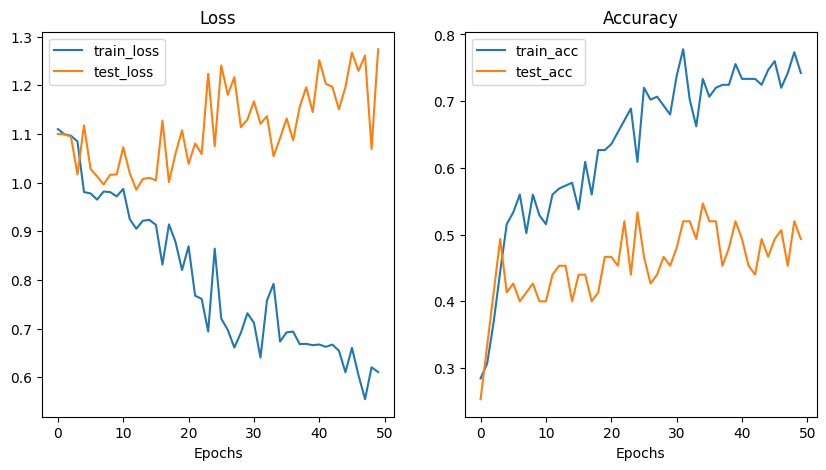

In [102]:
plot_loss_curves(model_1_results)

In [103]:
import pandas as pd 

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results) 

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.097687,0.360000
1,1.099814,0.328125,1.085293,0.413333
2,1.086864,0.488281,1.090853,0.426667
3,1.084249,0.398438,1.076099,0.466667
4,1.066230,0.414062,1.068836,0.493333
5,1.030724,0.437500,1.029225,0.440000
6,0.988110,0.421875,0.992793,0.480000
7,0.956029,0.585938,1.023947,0.480000
8,0.917969,0.597656,1.021188,0.413333
9,0.998654,0.464844,1.012543,0.453333


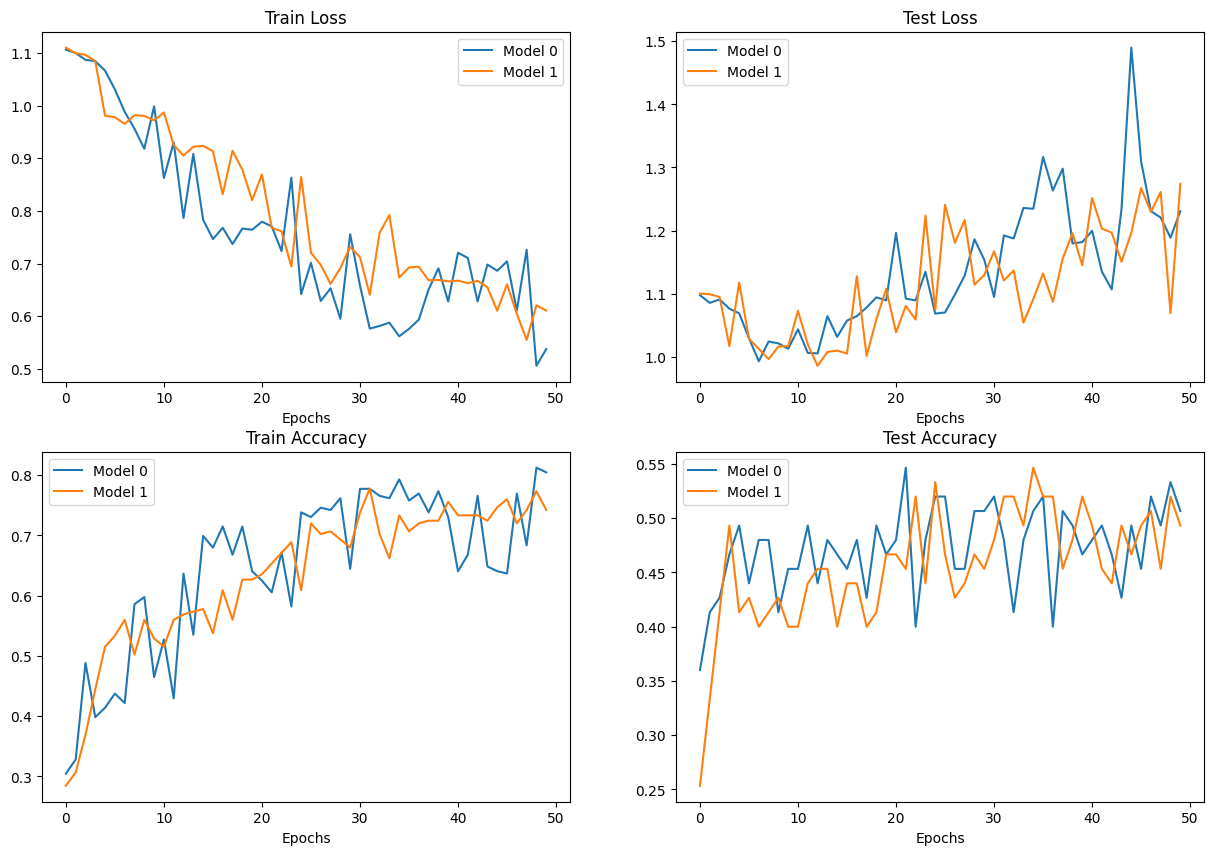

In [107]:
plt.figure(figsize=(15, 10)) 

epochs = range(len(model_0_results["train_loss"]))  

plt.subplot(2, 2, 1) 
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1") 
plt.title("Train Loss") 
plt.xlabel("Epochs") 
plt.legend() 

plt.subplot(2, 2, 2) 
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1") 
plt.title("Test Loss") 
plt.xlabel("Epochs") 
plt.legend() 

plt.subplot(2, 2, 3) 
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1") 
plt.title("Train Accuracy") 
plt.xlabel("Epochs") 
plt.legend() 

plt.subplot(2, 2, 4) 
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1") 
plt.title("Test Accuracy") 
plt.xlabel("Epochs") 
plt.legend() 


we can read an image into PyTorch using - https://pytorch.org/vision/main/io.html

torch.Size([3, 682, 1024])
torch.uint8


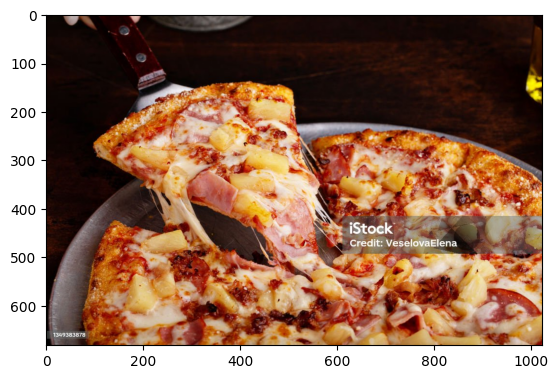

In [110]:
import torchvision 

custom_image_path = 'data/pizza_image_1024.jpg'
custom_image_uint8 = torchvision.io.read_image(custom_image_path)

print(custom_image_uint8.shape)
print(custom_image_uint8.dtype) 
plt.imshow(custom_image_uint8.permute(1, 2, 0)); 

torch.Size([3, 64, 64])
torch.float32
tensor(0.) tensor(0.9725)


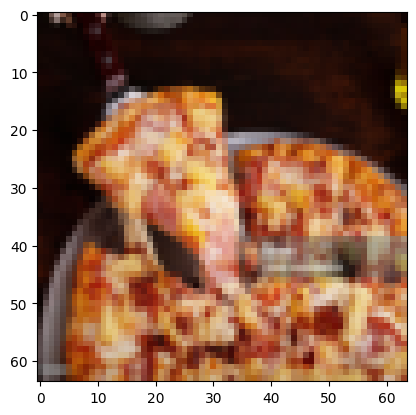

In [149]:
custom_image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(64, 64)), 
    transforms.ToTensor()
])

custom_image_transformed = custom_image_transform(custom_image_uint8) 
print(custom_image_transformed.shape) 
print(custom_image_transformed.dtype) 
print(custom_image_transformed.min(), custom_image_transformed.max()) 

plt.imshow(custom_image_transformed.permute(1, 2, 0)); 

In [119]:
model_1.eval() 
with torch.inference_mode(): 
    custom_image_pred = custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device)) 
    
custom_image_pred 

tensor([[-0.4827, -4.7898,  1.1889]])

* load the image and turn it into a tensor 
* make sure the image was the same datatype as the model (torch.float32) 
* make sure the image was the same shape as the data the model was trained with a batch size 
* make sure the image was on the same device as our model

In [123]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=-1)
custom_image_pred_probs

tensor([[0.1579, 0.0021, 0.8400]])

In [125]:
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=-1)
custom_image_pred_labels

tensor([2])

In [134]:
class_name = train_data_augmented.classes
class_name

['pizza', 'steak', 'sushi']

In [135]:
class_name[custom_image_pred_labels]

'sushi'

In [152]:
def pred_and_plot_image(model, image_path, class_names, transform, device): 
    
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.  # 0~255 uint8 -> 0~1 float32
    
    if transform: 
        target_image = transform(target_image) 
        
    model.to(device) 
    model.eval() 
    with torch.inference_mode(): 
        target_image = target_image.unsqueeze(0).to(device) 
        
        target_image_pred = model(target_image) 
        
    target_image_pred_probs = torch.softmax(target_image_pred, dim=-1)
    target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=-1) 
    
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) 
    
    if class_names: 
        title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}" 
    else: 
        title = f"Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}" 
        
    plt.title(title) 
    plt.axis(False) 

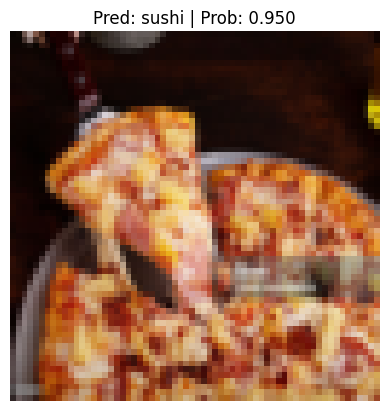

In [153]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

pred_and_plot_image(model_0, custom_image_path, class_name, custom_image_transform, device) 